In [ ]:
!pip install git+https://github.com/MassimoStel/emoatlas

In [ ]:
!python -m spacy download en_core_web_lg
!python -m spacy download it_core_news_lg

In [ ]:
PATH = "/content/emoatlas_csv.csv"




In [ ]:
from emoatlas import EmoScores
from tqdm import tqdm
import pandas as pd

EMOTIONS = ["joy", "trust", "fear", "surprise", "sadness", "disgust", "anger", "anticipation"]

models = {
    "english": EmoScores(language="english"),
    "italian": EmoScores(language="italian"),
}

def zscores_for_row(text, lang):
    """
    Extracts standardized emotion z-scores from EmoAtlas for a given text.
    Uses emo.zscores() if available (v≥0.4), otherwise falls back to
    emo.emotional_profile(use_zscores=True) for older versions.
    """
    emo = models.get(lang, models["english"])

    try:

        z = emo.zscores(text)
    except AttributeError:
        z = emo.emotional_profile(text, use_zscores=True)

    return {f"{e}_z": float(z.get(e, 0.0)) for e in EMOTIONS}

rows = []
for _, r in tqdm(df.iterrows(), total=len(df)):
    rows.append(zscores_for_row(r["Description"], r["lang_norm"]))

zdf = pd.DataFrame(rows)
out = pd.concat([df.reset_index(drop=True), zdf], axis=1)

out.head()



100%|██████████| 74/74 [00:01<00:00, 67.88it/s]


,Description,UserLanguage,GROUP,GroupLabel,lang_norm,joy_z,trust_z,fear_z,surprise_z,sadness_z,disgust_z,anger_z,anticipation_z
0,This painting remind me of an escape from the ...,EN,1,ASC,english,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"This work, the transition of people to each ot...",EN,1,ASC,english,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,I see people hugging each other and trying to ...,EN,1,ASC,english,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,It makes me feel both joy and suffering at the...,EN,1,ASC,english,0.756872,-0.636845,-0.632979,-0.828795,0.714584,-0.086253,-1.373153,1.066749
4,un’unione di corpi felici e colorati in primav...,IT,1,ASC,italian,3.897570,0.137552,-1.755510,-1.030142,-0.490693,-1.397723,-1.613125,-0.186260


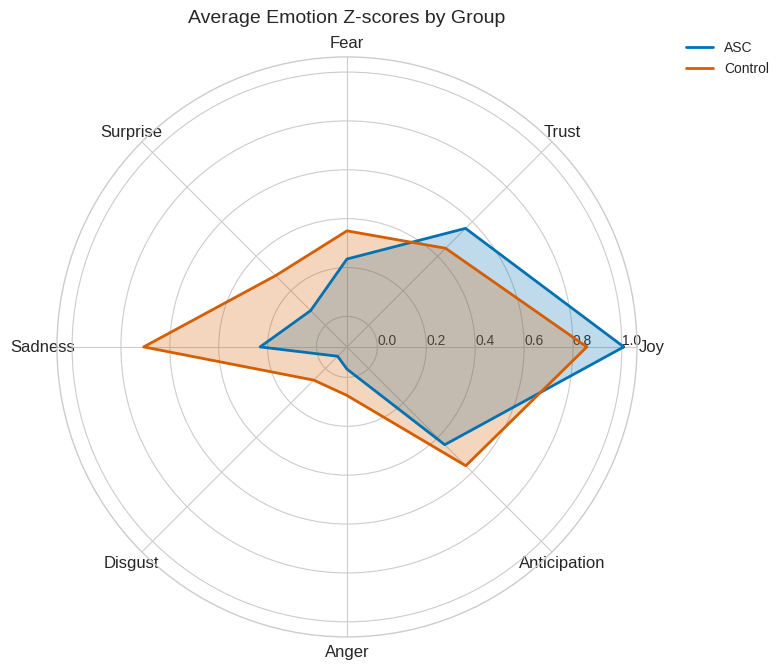

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure we use the same emotion order as EmoAtlas
EMOTIONS = ["joy","trust","fear","surprise","sadness","disgust","anger","anticipation"]

# Compute group means
mean_by_group = out.groupby("GroupLabel")[[f"{e}_z" for e in EMOTIONS]].mean()

# Reorder in circular order (Joy to Joy again for closure)
values_asc  = mean_by_group.loc["ASC"].to_list()
values_ctrl = mean_by_group.loc["Control"].to_list()
# close the circle
values_asc.append(values_asc[0])
values_ctrl.append(values_ctrl[0])

# Angle setup (8 emotions around a circle)
angles = np.linspace(0, 2*np.pi, len(EMOTIONS), endpoint=False).tolist()
angles += angles[:1]  # close loop

# --- Radar plot ---
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

# ASC
ax.plot(angles, values_asc, linewidth=2, linestyle='solid', color="#0072B2", label="ASC")
ax.fill(angles, values_asc, color="#0072B2", alpha=0.25)

# Control
ax.plot(angles, values_ctrl, linewidth=2, linestyle='solid', color="#D55E00", label="Control")
ax.fill(angles, values_ctrl, color="#D55E00", alpha=0.25)

# Axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels([e.capitalize() for e in EMOTIONS], fontsize=12)
ax.set_rlabel_position(0)
ax.set_title("Average Emotion Z-scores by Group", size=14, pad=25)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.05))
plt.tight_layout()
plt.show()
